# Forecast Taxa Selic

Estudo focado em entender a taxa Selic no Brasil e prevê-la nos próximos períodos. Além disso, será útil entender também qual a influência desta taxa nos investimentos de renda fixa.

## 0.0. Imports

In [90]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
import os

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 1.0. Coletando Dados

In [91]:
# colocando opcao para nao abrir o browser
options = webdriver.ChromeOptions()
options.add_argument('headless')

# instanciando driver
driver = webdriver.Chrome(service = Service(ChromeDriverManager().install()), options = options)

### 1.1. Selic

In [92]:
# obtendo html da tabela
url_selic = 'https://www.bcb.gov.br/controleinflacao/historicotaxasjuros'
driver.get(url_selic)
time.sleep(1)
html = driver.page_source
table = driver.find_element(By.ID, "historicotaxasjuros")
table_html = table.get_attribute('outerHTML')

In [93]:
# transformando html em dataframe
df_raw = pd.read_html(table_html)[0]
df_raw.columns = ['reuniao', 'data', 'vies', 'periodo_vigencia', 'meta_selic_aa', 'tban_am', 'taxa_selic', 'taxa_selic_aa']
df_raw.head()

,reuniao,data,vies,periodo_vigencia,meta_selic_aa,tban_am,taxa_selic,taxa_selic_aa
0,248º,03/08/2022,NaN,04/08/2022 -,1375,NaN,NaN,NaN
1,247º,15/06/2022,NaN,17/06/2022 - 03/08/2022,1325,NaN,168.0,1315.0
2,246º,04/05/2022,NaN,05/05/2022 - 16/06/2022,1275,NaN,143.0,1265.0
3,245º,16/03/2022,NaN,17/03/2022 - 04/05/2022,1175,NaN,145.0,1165.0
4,244º,02/02/2022,NaN,03/02/2022 - 16/03/2022,1075,NaN,113.0,1065.0


### 1.2. Desemprego

In [94]:
# obtendo html da tabela
url_desemprego = 'https://br.investing.com/economic-calendar/brazilian-unemployment-rate-411'
driver.get(url_desemprego)
time.sleep(1)

# clicar no "Exibir Mais" até o fim
exibir_mais = driver.find_element(By.LINK_TEXT, "Exibir mais")
i = 0
while exibir_mais:
    print(i, end = ', ')
    try:
        exibir_mais.click()
        time.sleep(1.5)
        exibir_mais = driver.find_element(By.LINK_TEXT, "Exibir mais")
    except:
        try:
            time.sleep(2)
            exibir_mais.click()
            time.sleep(1.5)
            exibir_mais = driver.find_element(By.LINK_TEXT, "Exibir mais")
        except:
            break
    i += 1

table = driver.find_element(By.ID, "eventHistoryTable411")
table_html = table.get_attribute('outerHTML')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 

In [95]:
# transformando html em dataframe
df_desemprego = pd.read_html(table_html)[0].iloc[:, :-1]
df_desemprego.columns = ['lancamento', 'hora', 'atual', 'projecao', 'anterior']
df_desemprego.shape

(246, 5)

## 2.0. Limpando e Manipulando Dados

### 2.1. Arrumando numéricos e data

**taxa_selic**, **meta_selic** e **taxa_selic_aa**: como o separador de decimal estava como vírgula, dividir valores por 100.

In [96]:
df2 = df_raw.copy()
df2_desemprego = df_desemprego.copy()

In [97]:
df2['meta_selic_aa'] = df2['meta_selic_aa'] / 100
df2['taxa_selic'] = df2['taxa_selic'] / 100
df2['taxa_selic_aa'] = df2['taxa_selic_aa'] / 100
df2.head()

,reuniao,data,vies,periodo_vigencia,meta_selic_aa,tban_am,taxa_selic,taxa_selic_aa
0,248º,03/08/2022,NaN,04/08/2022 -,13.75,NaN,NaN,NaN
1,247º,15/06/2022,NaN,17/06/2022 - 03/08/2022,13.25,NaN,1.68,13.15
2,246º,04/05/2022,NaN,05/05/2022 - 16/06/2022,12.75,NaN,1.43,12.65
3,245º,16/03/2022,NaN,17/03/2022 - 04/05/2022,11.75,NaN,1.45,11.65
4,244º,02/02/2022,NaN,03/02/2022 - 16/03/2022,10.75,NaN,1.13,10.65


**atual**, **projecao** e **anterior**: retirar % e trocar vírgula por ponto.

In [98]:
df2_desemprego['atual'] = df2_desemprego['atual'].str[:-2].replace(',', '.', regex = True).astype(float)
df2_desemprego['projecao'] = df2_desemprego['projecao'].str[:-2].replace(',', '.', regex = True).astype(float)
df2_desemprego['anterior'] = df2_desemprego['anterior'].str[:-2].replace(',', '.', regex = True).astype(float)
df2_desemprego.head()

,lancamento,hora,atual,projecao,anterior
0,29.07.2022,09:00,9.0,9.0,9.0
1,30.06.2022,09:00,9.0,NaN,10.0
2,31.05.2022,09:00,10.0,NaN,11.0
3,29.04.2022,09:00,11.0,11.0,11.0
4,31.03.2022,14:30,11.0,NaN,11.0


### 2.2. Transformando em granularidade diária

In [99]:
df2['data'] = pd.to_datetime(df2['data'], format = "%d/%m/%Y")
df2['periodo_vigencia_min'] = pd.to_datetime(df2['periodo_vigencia'].apply(lambda x: x[:10]), format = "%d/%m/%Y")
df2['periodo_vigencia_max'] = pd.to_datetime(df2['periodo_vigencia'].apply(lambda x: x[-10:] if len(x) == 23 else np.nan), format = "%d/%m/%Y")

df2_desemprego['lancamento'] = pd.to_datetime(df2_desemprego['lancamento'].str[:10], format = "%d.%m.%Y")
df2_desemprego['lancamento_lag'] = df2_desemprego['lancamento'].shift(1)
df2.head()

,reuniao,data,vies,periodo_vigencia,meta_selic_aa,tban_am,taxa_selic,taxa_selic_aa,periodo_vigencia_min,periodo_vigencia_max
0,248º,2022-08-03,NaN,04/08/2022 -,13.75,NaN,NaN,NaN,2022-08-04,NaT
1,247º,2022-06-15,NaN,17/06/2022 - 03/08/2022,13.25,NaN,1.68,13.15,2022-06-17,2022-08-03
2,246º,2022-05-04,NaN,05/05/2022 - 16/06/2022,12.75,NaN,1.43,12.65,2022-05-05,2022-06-16
3,245º,2022-03-16,NaN,17/03/2022 - 04/05/2022,11.75,NaN,1.45,11.65,2022-03-17,2022-05-04
4,244º,2022-02-02,NaN,03/02/2022 - 16/03/2022,10.75,NaN,1.13,10.65,2022-02-03,2022-03-16


In [100]:
df2_daily = pd.DataFrame(columns = ['data', 'selic'])
df2_daily_desemprego = pd.DataFrame(columns = ['data', 'desemprego'])

for index, row in df2.sort_values(by = 'data').iterrows():
    # definindo dia mínimo e máximo (se máximo for nulo, colocar data de hoje)
    min_date = row['periodo_vigencia_min']
    max_date = row['periodo_vigencia_max'] if not pd.isnull(row['periodo_vigencia_max']) else pd.Timestamp.today()
    
    df_append = pd.DataFrame({'data': pd.date_range(min_date, max_date, freq='D')})
    df_append['selic'] = row['meta_selic_aa']
    df2_daily = pd.concat([df2_daily, df_append])

for index, row in df2_desemprego.sort_values(by = 'lancamento').iterrows():
    # definindo dia mínimo e máximo (se máximo for nulo, colocar data de hoje)
    min_date = row['lancamento']
    max_date = row['lancamento_lag'] if not pd.isnull(row['lancamento_lag']) else pd.Timestamp.today()
    
    df_append = pd.DataFrame({'data': pd.date_range(min_date, max_date, freq='D')})
    df_append['desemprego'] = row['atual']
    df2_daily_desemprego = pd.concat([df2_daily_desemprego, df_append])

df2_daily['ano'] = df2_daily['data'].dt.year
df2_daily['mes'] = df2_daily['data'].dt.month

df2_daily = df2_daily.merge(df2_daily_desemprego, on = ['data'])

df2_daily.head()

,data,selic,ano,mes,desemprego
0,2001-11-01,19.0,2001,11,11.7
1,2001-11-02,19.0,2001,11,11.7
2,2001-11-03,19.0,2001,11,11.7
3,2001-11-04,19.0,2001,11,11.7
4,2001-11-05,19.0,2001,11,11.7


### 2.3. Limpeza de dados

Visto que as taxas de juros só começaram a ser fixadas na expressão anual a partir de 02/01/1998, dados antes desta data serão ignorados.

In [101]:
df2_daily.shape

(7843, 5)

In [102]:
df2_daily = df2_daily.query('data >= "1998-01-02"')

In [103]:
df2_daily.shape

(7843, 5)

### 2.4. Transformando em granularidade mensal

Para obter a taxa Selic mensal, transforma-se a base em granularidade diária e então calcula-se a média ponderada no mês da taxa.

In [104]:
# calculando média ponderada
aux = df2_daily.groupby(['ano', 'mes', 'selic']).count().reset_index()
wm = lambda x: np.average(x, weights = aux.loc[x.index, "data"])
df2_monthly = aux.groupby(['ano', 'mes']).agg({'selic': wm}).reset_index()

aux_desemprego = df2_daily.groupby(['ano', 'mes', 'desemprego']).count().reset_index()
wm_desemprego = lambda x: np.average(x, weights = aux_desemprego.loc[x.index, "data"])
df2_monthly_desemprego = aux_desemprego.groupby(['ano', 'mes']).agg({'desemprego': wm_desemprego}).reset_index()

df2_monthly = df2_monthly.merge(df2_monthly_desemprego, on = ['ano', 'mes'])
df2_monthly['data'] = pd.to_datetime(df2_monthly['ano'].astype(str) + '-' + df2_monthly['mes'].astype(str), format = "%Y-%m")
df2_monthly

,ano,mes,selic,desemprego,data
0,2001,11,19.000000,11.700000,2001-11-01
1,2001,12,19.000000,11.506250,2001-12-01
2,2002,1,19.000000,10.628125,2002-01-01
3,2002,2,18.931034,11.082759,2002-02-01
4,2002,3,18.664062,12.456250,2002-03-01
...,...,...,...,...,...
245,2022,4,11.750000,11.000000,2022-04-01
246,2022,5,12.625000,10.968750,2022-05-01
247,2022,6,12.991935,9.967742,2022-06-01
248,2022,7,13.250000,9.000000,2022-07-01


## 3.0. Feature Engineering

In [105]:
df3 = df2_monthly.copy()

### 3.1. Anos de eleição

Eleições acontecem a cada 4 anos, sendo a primeira em 1998 na nossa base de dados.

In [106]:
# eleicao
years_eleicao = np.arange(1994, pd.Timestamp.today().year + 1, 4)
df3.loc[df3['ano'].isin(years_eleicao), 'eleicao'] = 1
df3['eleicao'] = df3['eleicao'].fillna(0)

## 4.0. EDA

In [107]:
df4 = df3.copy()

### 4.1. Eleição e Desemprego

Sabe-se que anos de eleição costumam agitar o país e serem anos mais instáveis. Não é possível identificar um padrão claro do comportamento da taxa Selic nesses períodos, fora o fato de que, pós eleição de um novo presidente, a taxa costuma subir (1998, 2002, 2010, 2014), com exceção de 2006 (reeleição de Lula) e 2018 (eleição de Bolsonaro).

Em relação ao desemprego, verifica-se que há uma tendência diretamente proporcional a Selic até 2017, aproximadamente, onde a taxa de desemprego se manteve praticamente constante em altas taxas enquanto a taxa Selic caia.

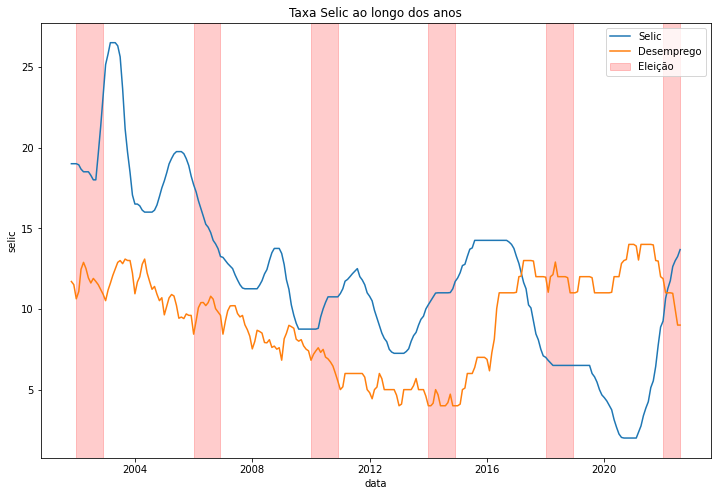

In [108]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.lineplot(data = df4, x = 'data', y = 'selic', ax = ax, label = 'Selic');
sns.lineplot(data = df4, x = 'data', y = 'desemprego', ax = ax, label = 'Desemprego');
max_min_date_year = df4.query("eleicao == 1").groupby('ano')['data'].agg(['min', 'max'])

for index, row in max_min_date_year.iterrows():
    if index == 2002:
        ax.axvspan(row['min'], row['max'], alpha=0.2, color='red', label = 'Eleição')
    else:
        ax.axvspan(row['min'], row['max'], alpha=0.2, color='red')

ax.set_title('Taxa Selic ao longo dos anos');
plt.legend();

### 4.2. Sazonalidade

Verifica-se que o ano de maior variação da Selic após 2000 foi 2003. Fora isso, ao longo do ano a Selic tende a variar pouco. Verifica-se também baixa variação ao longo dos meses, não demonstrando uma sazonalidade clara.

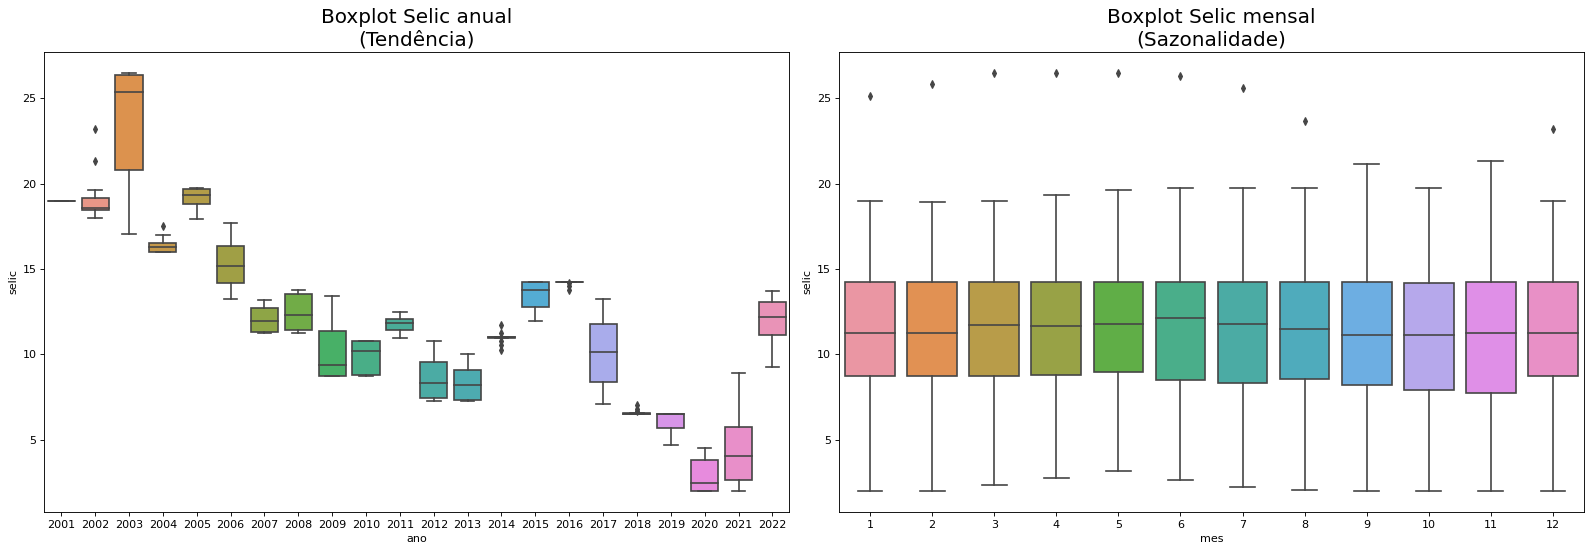

In [109]:
# Ano e Mês
years = df4['ano']
months = df4['mes']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='ano', y='selic', data=df4, ax=axes[0]);
sns.boxplot(x='mes', y='selic', data=df4);

axes[0].set_title('Boxplot Selic anual\n(Tendência)', fontsize=18); 
axes[1].set_title('Boxplot Selic mensal\n(Sazonalidade)', fontsize=18);
plt.tight_layout();

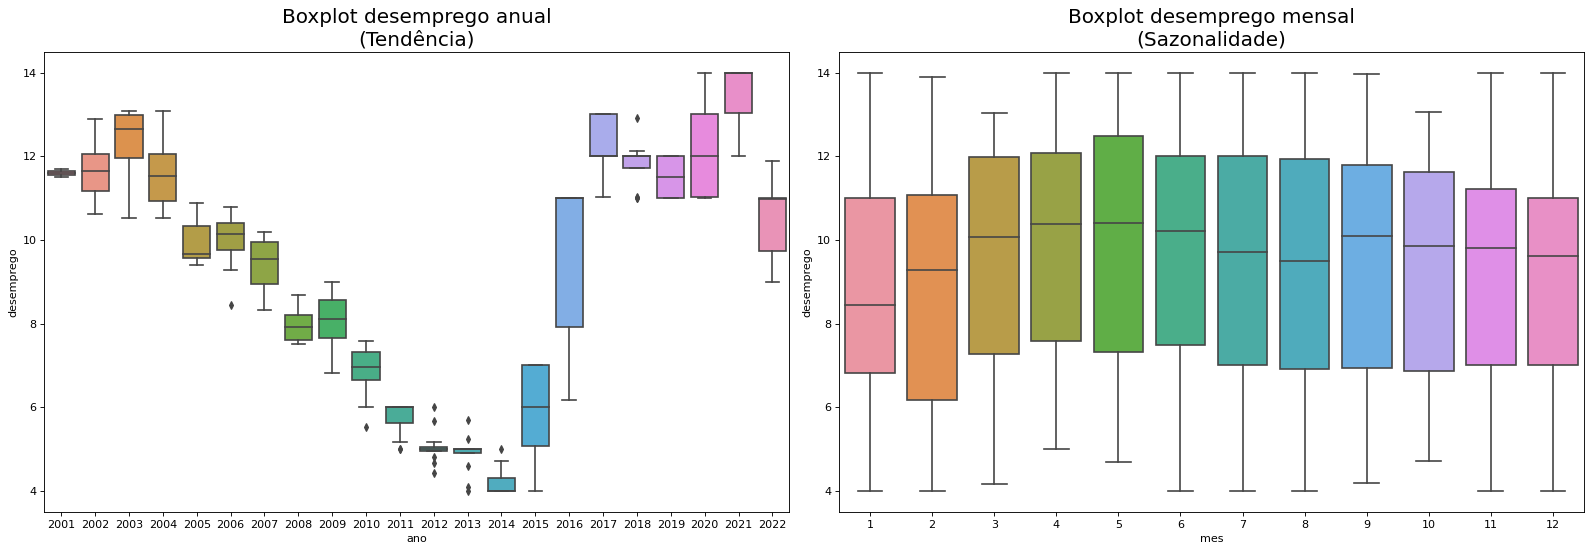

In [110]:
# Ano e Mês
years = df4['ano']
months = df4['mes']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='ano', y='desemprego', data=df4, ax=axes[0]);
sns.boxplot(x='mes', y='desemprego', data=df4);

axes[0].set_title('Boxplot desemprego anual\n(Tendência)', fontsize=18); 
axes[1].set_title('Boxplot desemprego mensal\n(Sazonalidade)', fontsize=18);
plt.tight_layout();

### 4.3. Autocorrelação e Autocorrelação Parcial

A autocorrelação indica a correlação de Pearson da série com seus lags. Já a autocorrelação parcial é a correlação com os lags, mas removendo o efeito de lags intermediários.

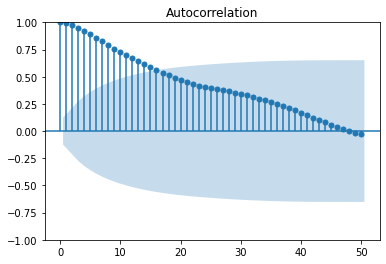

In [111]:
# autocorrelacao
plot_acf(df4['selic'], lags = 50);

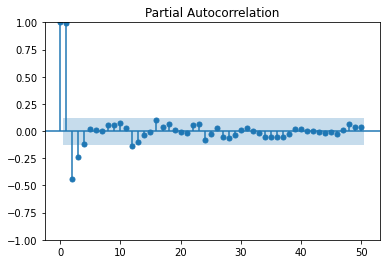

In [112]:
# autocorrelacao parcial
plot_pacf(df4['selic'], lags = 50, method='ywm');

## 5.0. Preparação dos dados

## 6.0. Machine Learning

In [113]:
df5 = df4.copy()

### 6.1. ARIMA